In [1]:
# Useful for defining quantities
from astropy import units as u
import numpy as np
# Earth focused modules, ISS example orbit and time span generator
from poliastro.earth import EarthSatellite
from poliastro.earth.plotting import GroundtrackPlotter
from poliastro.examples import iss
from poliastro.util import time_range

from poliastro.bodies import Earth #przenieść na moon?/ mars?
from poliastro.twobody import Orbit

import numpy as np
import math
import random
import matplotlib.pyplot as plt

In [2]:

#https://www.n2yo.com/satellite/?s=39019
# Define the semi-major axis (a), eccentricity (ecc), inclination (inc), 
# longitude of the ascending node (raan), argument of perigee (argp), and true anomaly (nu)
planet_radius = 6371
a =  planet_radius * u.km  # semi-major axis
ecc = 0 * u.one  # eccentricity
inc = 98.2 * u.deg  # inclination - sprawdzone
raan = (((360.0) / 365.242199) / 24.0) / 3600.0 * u.deg  # longitude of the ascending node - sprawdzone
argp = 360 * u.deg  # argument of perigee #skąd ma startować?
nu = np.pi / 5 * u.deg  # true anomaly
swath = 16 * u.km

# Define the epoch of the orbit
epoch = iss.epoch

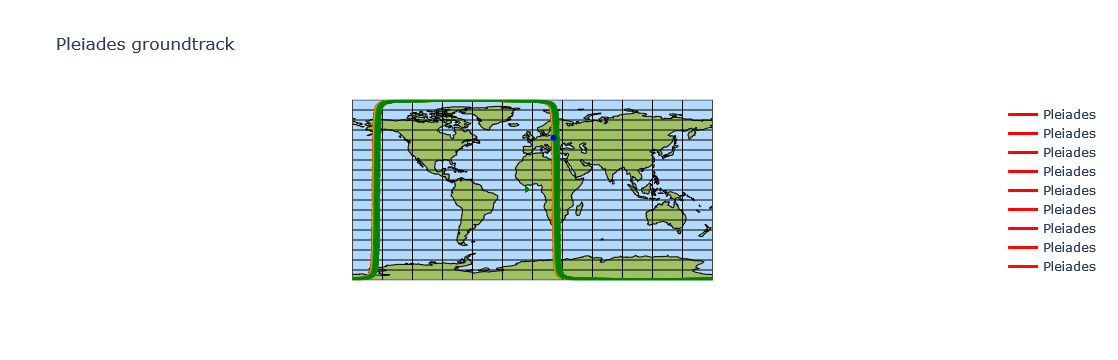

In [53]:
#testowanie_Kacpra
a = 7071 * u.km
inc = 89.6 * u.deg
raan = 350.0265 * u.deg
orbits = []
new_satelites = []
times = []
periods = 5917.417835241439
how_often = (24.0 * 3600.0) / periods
around = 23.934 #ile godzin trwa obrót ziemii wokół własnej osi
sun_ten = (10.0 / 24.0) * around
n = 360 #liczba dni
pleiades_orbit = Orbit.from_classical(Earth, a, ecc, inc, raan, argp, nu, epoch)
for i in range(n):
    orbits.append(Orbit.from_classical(Earth, a, ecc, inc, raan, argp, nu, epoch))
    new_satelites.append(EarthSatellite(orbits[i], None))
    times.append(time_range(
        pleiades_orbit.epoch + (i * around + sun_ten) * u.h, periods=150, end=pleiades_orbit.epoch + (i * around + sun_ten + 0.24 ) * u.h ))
pleiades_orbit = Orbit.from_classical(Earth, a, ecc, inc, raan, argp, nu, epoch)

# Build spacecraft instance
pleiades_spacecraft = EarthSatellite(pleiades_orbit, None)

# Generate an instance of the plotter, add title and show latlon grid
gp = GroundtrackPlotter()
gp.update_layout(title="Pleiades groundtrack")

from colour import Color
red = Color("red")
colors = list(red.range_to(Color("green"),n))

# Plot previously defined EarthSatellite object
for i in range(n):
    gp.plot(
        new_satelites[i],
        times[i],
        label="Pleiades",
        color=str(colors[i]),
        line_style = {"width": 3 , "color": str(colors[i])},
        marker={
            "size": 0,
            "symbol": "triangle-right",
            "line": {"width": 0, "color": "black"},
        },
    )
# For building geo traces
import plotly.graph_objects as go

# Let us add a new trace in original figure
WWA = [52.2297, 21.0122] * u.deg
gp.add_trace(    
    go.Scattergeo(
        lat=WWA[0],
        lon=WWA[-1],
        name="WWA",
        marker={"color": "blue"},
        )
)

gp.fig.show()


In [26]:
# Create the orbit
orbits = []
new_satelites = []
times = []
n = 100
pleiades_orbit = Orbit.from_classical(Earth, a, ecc, inc, raan, argp, nu, epoch)
for i in range(n):
    orbits.append(Orbit.from_classical(Earth, a, ecc, inc, raan, (argp * i) / float(n), nu, epoch))
    new_satelites.append(EarthSatellite(orbits[i], None))
    times.append(time_range(
        pleiades_orbit.epoch + ( i * 0.25 )  * u.h, periods=150, end=pleiades_orbit.epoch + ( (i + 1) * 0.25) * u.h ))
pleiades_orbit = Orbit.from_classical(Earth, a, ecc, inc, raan, argp, nu, epoch)

# Build spacecraft instance
pleiades_spacecraft = EarthSatellite(pleiades_orbit, None)

In [44]:
#haversine formula - odległość kątowa między dwoma punktami na Ziemii
def haversine(r_long, r_lat, s_long, s_lat, planet_radius):
    return 2 * planet_radius * np.arcsin(np.sqrt( (1 - np.cos(s_lat - r_lat) + np.cos(s_lat) * np.cos(r_lat) * (1 - np.cos(s_long - r_long))) / 2   ))

#kąt który mówi czy satelita jest widziany przez odbiornik
def seeable_angle(planet_radius, s_alt):
    return np.arccos(planet_radius / (planet_radius + s_alt))

def is_vis2(receiver_long, receiver_lat, satellite_lat, satellite_long, satellite_alt, planet_radius):
    return np.fabs(haversine(receiver_long, receiver_lat, satellite_long, satellite_lat, planet_radius)) < np.fabs(seeable_angle(planet_radius, satellite_alt))

In [45]:

def find_visible_circle(receiver_long, receiver_lat, satellite_alt, planet_radius):
    #nie wpisywać biegunów, bo tam są błędy zmiennoprzecinkowe chyba
    if receiver_lat == 90:
        receiver_lat = 89.99
    elif receiver_lat == -90:
        receiver_lat = -89.99
    distance_rad = seeable_angle(planet_radius, satellite_alt)
    long_rad = math.radians(receiver_long)
    lat_rad = math.radians(receiver_lat)
    
    random_points = []
    m = 100
    for i in range(m):
        # Generate a random bearing (direction) in radians
        bearing = ((2 * math.pi * i )/ m) - math.pi 

        # Calculate the new latitude and longitude
        new_lat_rad = math.asin(math.sin(lat_rad)*math.cos(distance_rad) +
                                math.cos(lat_rad)*math.sin(distance_rad)*math.cos(bearing))
        new_long_rad = long_rad + math.atan2(math.sin(bearing)*math.sin(distance_rad)*math.cos(lat_rad),
                                             math.cos(distance_rad)-math.sin(lat_rad)*math.sin(new_lat_rad))

        # Convert the new latitude and longitude from radians to degrees
        new_lat = math.degrees(new_lat_rad) 
        new_long = math.degrees(new_long_rad) - receiver_long

        # Add the new coordinates to the list
        random_points.append((new_long, new_lat))

    return random_points



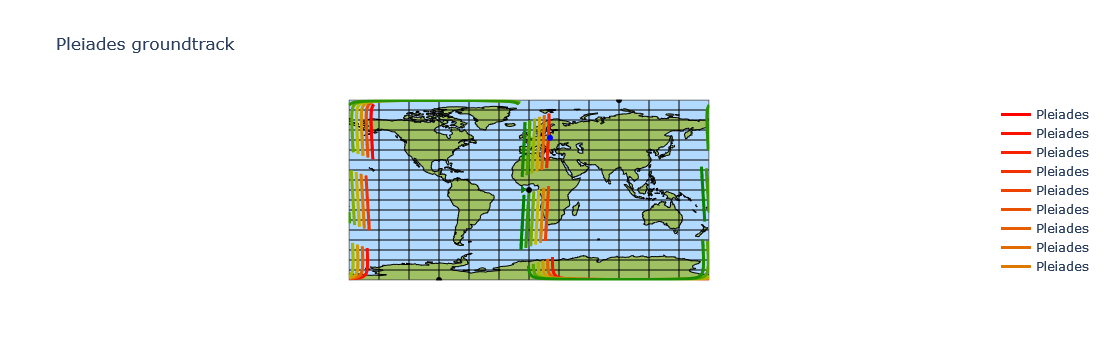

In [29]:
# Generate an instance of the plotter, add title and show latlon grid
gp = GroundtrackPlotter()
gp.update_layout(title="Pleiades groundtrack")

from colour import Color
red = Color("red")
colors = list(red.range_to(Color("green"),n))

# Plot previously defined EarthSatellite object
for i in range(n):
    gp.plot(
        new_satelites[i],
        times[i],
        label="Pleiades",
        color=str(colors[i]),
        line_style = {"width": 3 , "color": str(colors[i])},
        marker={
            "size": 0,
            "symbol": "triangle-right",
            "line": {"width": 0, "color": "black"},
        },
    )
# For building geo traces
import plotly.graph_objects as go

# Position in [LAT LON]
STATIONS = []
num_st = 4
for j in range(num_st):
    STATION = [((360 * j) / num_st) - 180, ((360 * j) / num_st) - 180] * u.deg
    STATIONS.append(STATION)

for j in range(num_st):
    gp.add_trace(    
        go.Scattergeo(
            lat=STATIONS[j][0],
            lon=STATIONS[j][-1],
            name="Odbiornik",
            marker={"color": "black"},
            )
    )
gp.fig.show()


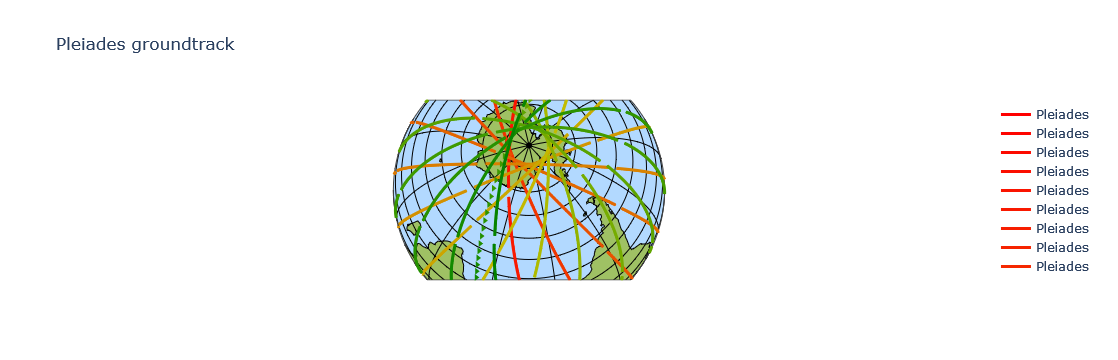

In [33]:
# Switch to three dimensional representation
gp.update_geos(projection_type="orthographic")
gp.fig.show()

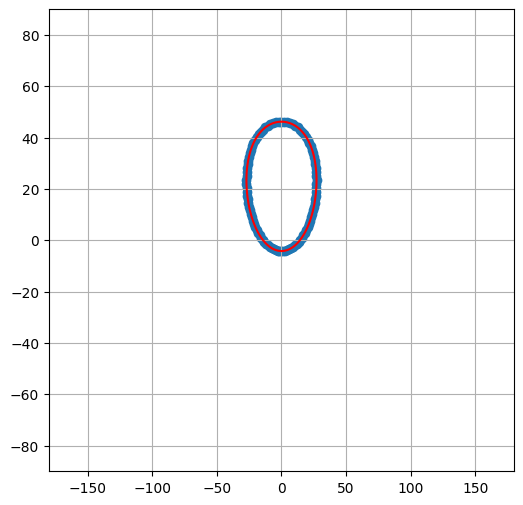

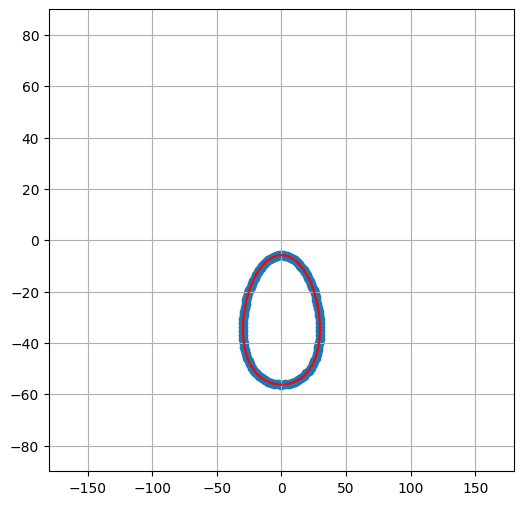

In [48]:
points_to_plot = find_visible_circle(52.22, 21.01, 670, planet_radius)

# Unzip the points to get the x and y coordinates.
x, y = zip(*points_to_plot)

# Create the plot
plt.figure(figsize=(6,6))
plt.scatter(x, y)
plt.plot(x, y, 'r')
plt.xlim(-180, 180)
plt.ylim(-90, 90)
plt.grid(True)

points_to_plot = find_visible_circle(72.22, -31.01, 670, planet_radius)

# Unzip the points to get the x and y coordinates.
x, y = zip(*points_to_plot)

# Create the plot
plt.scatter(x, y)
plt.plot(x, y, 'r')
plt.xlim(-180, 180)
plt.ylim(-90, 90)
plt.grid(True)

plt.show()